In [244]:
import pandas as pd
import math as mt
import re
import numpy as np
import matplotlib.pyplot as plt

from helpers import get_claims, concantenate_claims, checkRoman

## apply NLP

pre: patents sorted from earliest to latest patent

In [245]:
names = ["FW", "LC", "LIB",  "SC", "SPV", "Wind"]  # technology file names
n = "SC"  # other tech

In [246]:
df = pd.read_excel(f'sorted_data/DB_{n}_USPTO_sorted.xlsx')
df['Publn_Nr'] = df['Publn_Nr'].astype(int)

In [247]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import operator
import re

In [248]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [249]:
patent_claims = []  # list to store all patents claims for technology for year
list_replace = []
stwrds = stopwords.words('english')
stemmer = SnowballStemmer('english')


In [250]:
def get_tokens(text: str) -> tuple[list, dict]:
    # Standardize greek letters and eliminate symbols
    line = text.strip().lower()
    # Standardize greek letters and eliminate symbols
    for r in list_replace:
        line = line.replace(*r)
    # Replace .sub. and .sup. in each patent
    line = line.replace('.sub.', '')
    line = line.replace('.sup.', '')
    # Extract tokens using a regular expression
    tokens = re.findall('[a-z0-9][a-z0-9-]*[a-z0-9]+|[a-z0-9]', line)
    tokens = set(tokens)
    # Remove stopwords, and words of only one char and compossed only
    # of numbers
    tokens = [token for token in tokens if len(token) > 1 and
                token not in stwrds and
                not token.replace('-', '').isnumeric()]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = set(tokens)
    tokens = list(tokens)
    tokens.sort()
    tokens = [token for token in tokens if len(token) > 1 and
                token not in stwrds and
                not checkRoman(token)]
    count = {}
    # count occurances of each token
    for token in tokens:
        c = text.count(token)
        if c > 0:
            count[token] = c
        else:   # discard if token does not occur in text
            tokens.remove(token)
    # # sort tokens by frequency
    # tokens = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    return tokens, count

In [251]:
def update_total_counts(counts_total: dict, c2: dict):
    """
    add words from c2 to counts_total
    """
    for t, c in c2.items():
        if t in counts_total:
            counts_total[t] += c
        else:
            counts_total[t] = c

In [252]:
def get_entropy(counts: dict) -> float:
    """
    Calculate the entropy of a dictionary of token counts
    """
    entropy = 0
    total = sum(counts.values())
    for _, count in counts.items():
        p = count / total
        entropy += p * mt.log2(1/p)
    return entropy

In [253]:
def get_cross_entropy(counts: dict, counts_2: dict) -> float:
    """
    Calculate the cross-entropy of a dictionary of token counts

    if token not in count_2, then q = p
    
    """
    entropy = 0
    total = sum(counts.values())
    for token, count in counts.items():
        if count > 0:
            p = count / total
            if token in counts_2:
                q = counts_2[token] / total
                entropy = p * mt.log2(1/q)
            else:
                entropy = p * mt.log2(1/p)
    return entropy

In [ ]:
# get claims ordered by publication date
total_entropies = []  
entropies = []   # conditional entropies for each patent, sorted by publication date
counts_total = {}

counts_dict = {}

j = -1
for pub_nr in df['Publn_Nr'].unique():
    claims = get_claims(df, pub_nr)
    if claims.empty:
        entropies.append(np.nan)  # add NA if no claims in data set
        continue    # skip if no claims in data set
    text = concantenate_claims(claims)  # concantenate claims
    tokens, count = get_tokens(text)    # get tokens and counts of words

    update_total_counts(counts_total, count)  # update total counts for conditional entropy
    
    """
    conditional entropy
    H(X|Y) = H(X,Y) - H(Y)
    """
    
    e = get_entropy(counts_total)   # updated total entropy
    total_entropies.append(e)
    if j >= 0:
        cond_entropy = e - total_entropies[j]  
        entropies.append(cond_entropy)
    else:
        entropies.append(e)
    j += 1
    
    
    # entropy_Y = get_entropy(counts_total)
    # counts_total = get_total_counts(counts_total, count)  # update total counts for conditional entropy
    # entropy = get_entropy(counts_total) - entropy_Y
    # entropies.append(entropy)

    # get entropy of compared to the last 20 patents
    """
    H_Y(X) where Y is the last 20 patents, X is the new patent
    it shows a very fluctuating plot, as expected, as the innovation is always "normalized" compared to the last 20 patents
    """
    # counts_dict[pub_nr] = count
    # if len(counts_dict) > 20:
    #     last_20 = dict(list(counts_dict.items())[-20:])
    #     cond_entropy = get_cross_entropy(count, last_20)
    #     entropies.append(cond_entropy)
    # else:
    #     entropies.append(np.nan)
    
    
    # get single entropy
    """
    similar to H_Y(X) 
    """
    # cond_entropy = get_entropy(count)
    

In [ ]:
df_unique = df.drop_duplicates(subset=['Publn_Nr'])[['Publn_Nr', 'Publn_Date']]
df_unique['Entropy'] = entropies

In [ ]:
df_unique['Publn_Date'] = pd.to_datetime(df_unique['Publn_Date'])

In [ ]:
start = df_unique['Publn_Date'].values[0]
end = start + pd.DateOffset(years=1)

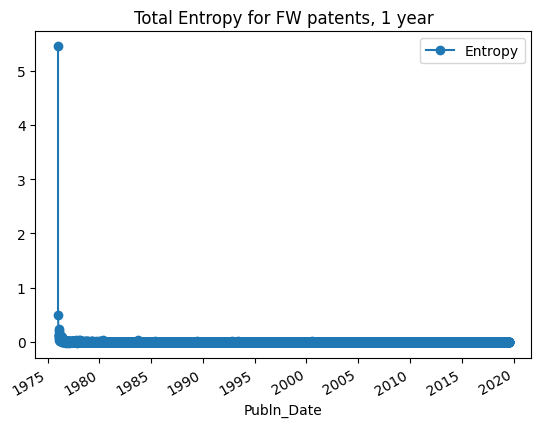

In [ ]:
df_unique.plot(x='Publn_Date', y='Entropy', kind='line', marker='o', title=f'Total Entropy for {n} patents, 1 year')
# plt.xlim(start, end)
plt.show()

In [ ]:
df_unique.to_csv(f'entropy_data/cond_entropy_{n}.csv', index=False)